# Домашнее задание «Модели ARIMA»


Выберите ряд из первого задания и постройте его модель ARIMA. Отчет нужно будет оформить в jupyter-ноутбук.

Дополнительное задание: попробуйте спрогнозировать график классическим ML.

In [84]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.tsa
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline

In [94]:
import warnings
warnings.filterwarnings('ignore')

# Функции для отображения графиков и подсчета статистик

In [86]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [87]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

# Попробуем временной ряд по ограблениям в Бостоне

In [88]:
robberies_in_boston = pd.read_csv("/Users/glebmutovin/Data_Science/DataScience_Netology/Machine_learning/TimeSeries/1._Лекция/Series/monthly-boston-armed-robberies-j.csv")['Count']

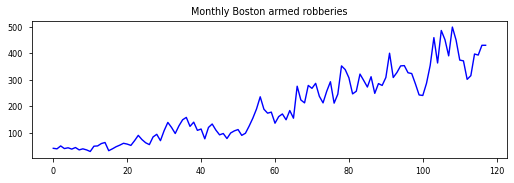

In [89]:
with plt.style.context('seaborn-paper'):
    plt.figure(figsize=(14, 7))
    layout = (3, 2)
    x = 1 % 2
    y = int((1 - x) / 2)
    ts_ax = plt.subplot2grid(layout, (y, x))
    robberies_in_boston.plot(ax=ts_ax, color='blue')
    ts_ax.set_title('Monthly Boston armed robberies')
        
    plt.tight_layout()

Строим модель ARIMA с оптимальными значениями гиперпараметров

aic: 915.44167 | order: (0, 0, 1)
Results of Dickey-Fuller Test:
Test Statistic                   0.959326
p-value                          0.993818
#Lags Used                      12.000000
Number of Observations Used    105.000000
Critical Value (1%)             -3.494220
Critical Value (5%)             -2.889485
Critical Value (10%)            -2.581676
dtype: float64


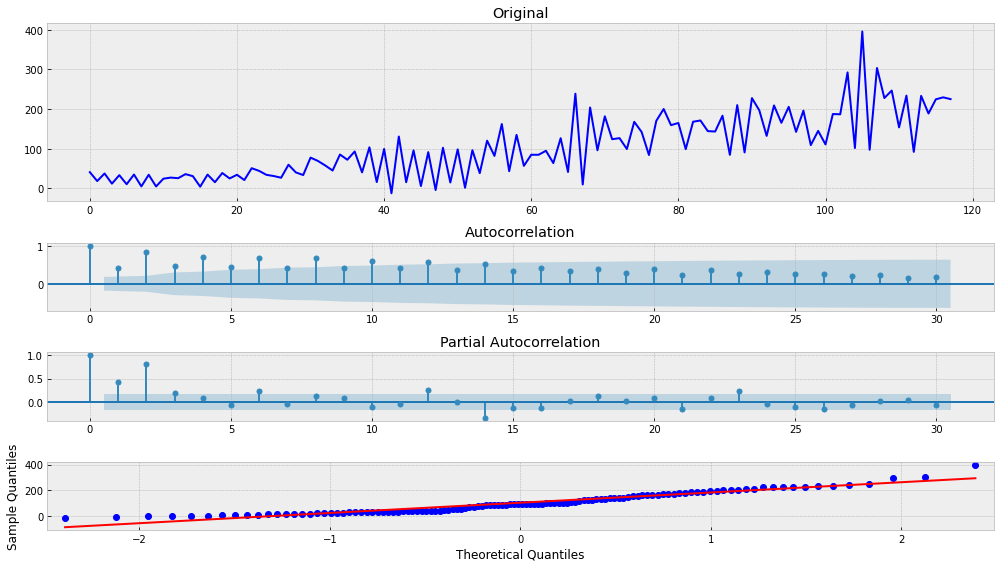

In [95]:
best_aic = np.inf
best_order = None
best_model = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_model = smt.ARIMA(robberies_in_boston, order=(i,d,j)).fit(method='mle', trend='nc')
                tmc_aic = tmp_model.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_model = tmp_model
            except: continue
                
print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

tsplot(best_model.resid, lags=30)

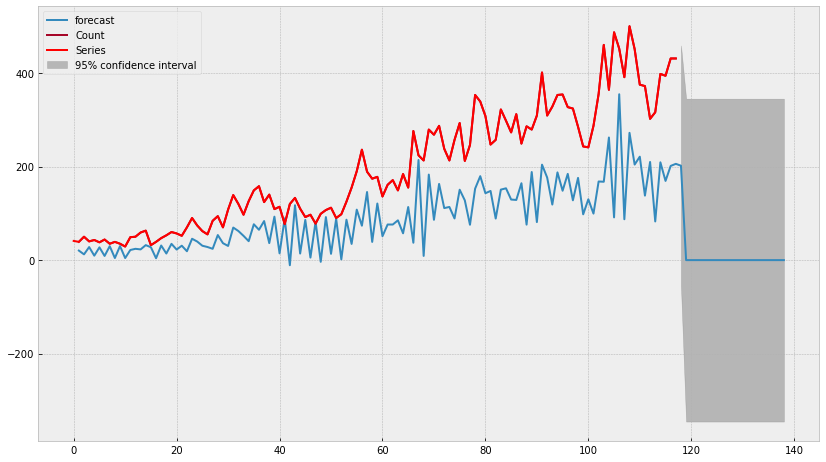

In [25]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    best_model.plot_predict(1, len(robberies_in_boston['Count'])+20, ax=ax)
    plt.plot(robberies_in_boston['Count'], color='red', label='Series')
    plt.legend()
    plt.show()

Выглядит очень плохо. Можно попробовать предварительно сделать преобразование boxcox.

Results of Dickey-Fuller Test:
Test Statistic                  -2.013161
p-value                          0.280833
#Lags Used                      10.000000
Number of Observations Used    107.000000
Critical Value (1%)             -3.492996
Critical Value (5%)             -2.888955
Critical Value (10%)            -2.581393
dtype: float64


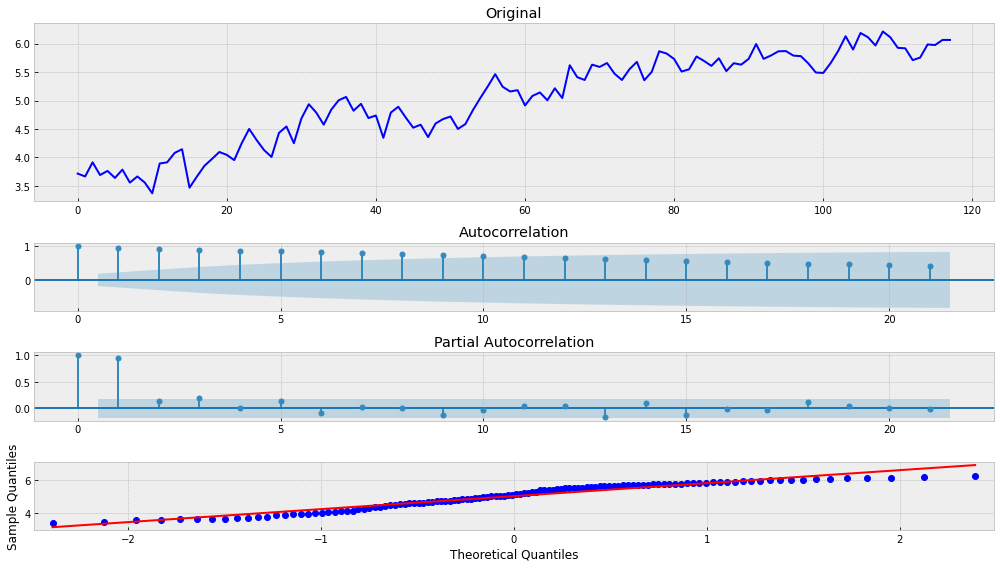

In [32]:
series_1 = pd.read_csv("/Users/glebmutovin/Data_Science/DataScience_Netology/Machine_learning/TimeSeries/1._Лекция/Series/monthly-boston-armed-robberies-j.csv")['Count']
series_1 = boxcox(series_1, 0)
tsplot(series_1)

aic: -44.47600 | order: (2, 1, 4)
Results of Dickey-Fuller Test:
Test Statistic                -1.122897e+01
p-value                        1.928655e-20
#Lags Used                     0.000000e+00
Number of Observations Used    1.160000e+02
Critical Value (1%)           -3.488022e+00
Critical Value (5%)           -2.886797e+00
Critical Value (10%)          -2.580241e+00
dtype: float64


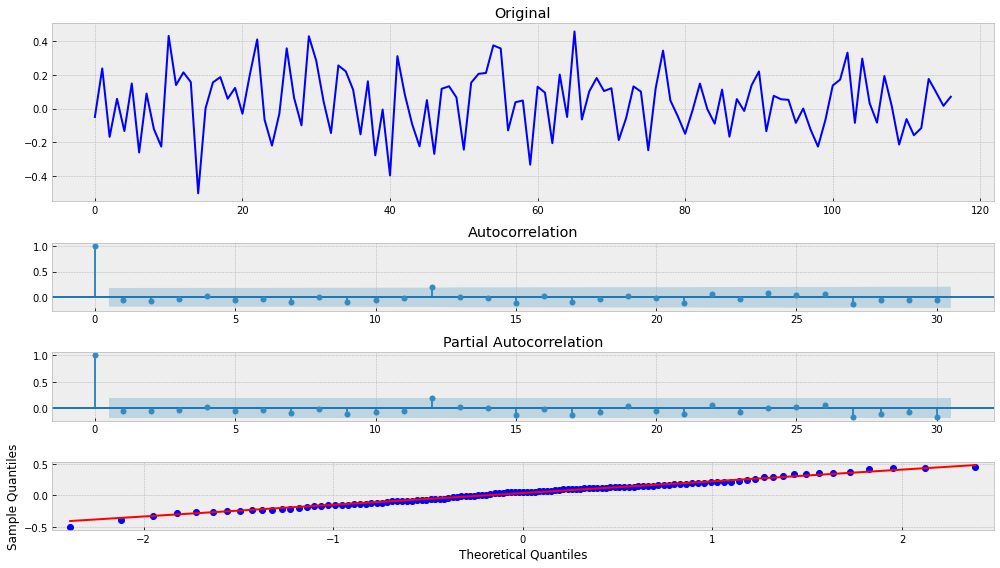

In [96]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = smt.ARIMA(series_1, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


tsplot(best_mdl.resid, lags=30)

Видим, что остатки распределены нормально.

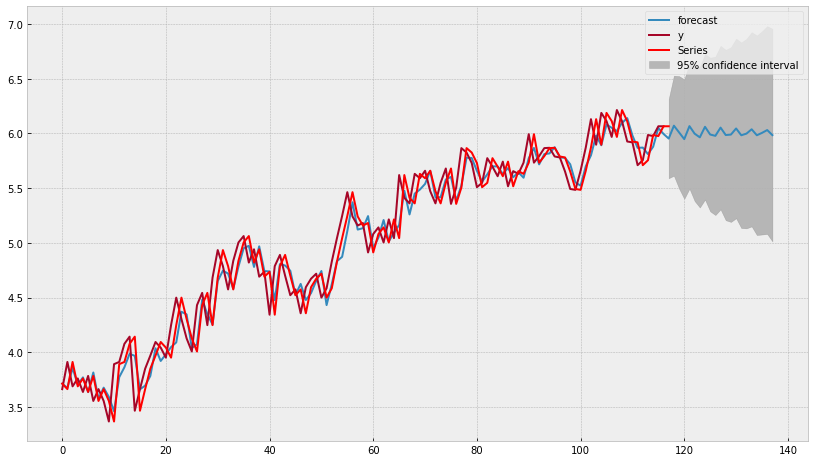

In [34]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    best_mdl.plot_predict(1, len(series_1)+20, ax=ax)
    plt.plot(series_1, color='red', label='Series')
    plt.legend()
    plt.show()

# Попробуем временной ряд по продажам за месяц в компании Х

aic: 858.17298 | order: (3, 1, 2)
Results of Dickey-Fuller Test:
Test Statistic                 -2.024906
p-value                         0.275760
#Lags Used                     11.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


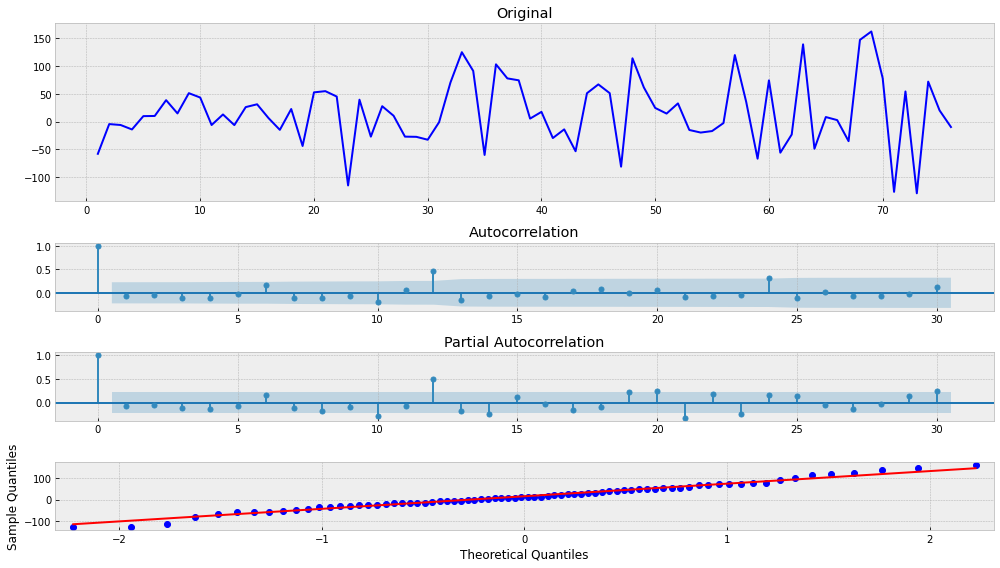

In [97]:
series = pd.read_csv("/Users/glebmutovin/Data_Science/DataScience_Netology/Machine_learning/TimeSeries/1._Лекция/Series/monthly-sales-of-company-x-jan-6.csv")['Count']

best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = smt.ARIMA(series, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


tsplot(best_mdl.resid, lags=30)

Наименьшее значение "aic" достигается при p = 3 (порядок авторегрессии), d = 1 (сколько раз берем разность для дифференцирования), q = 2 (кол-во значений предыдущих ошибок прогноза)

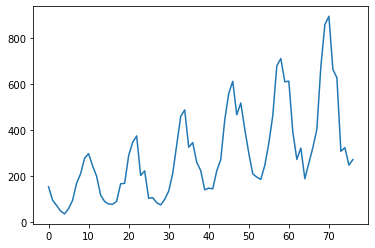

In [47]:
plt.plot(series)

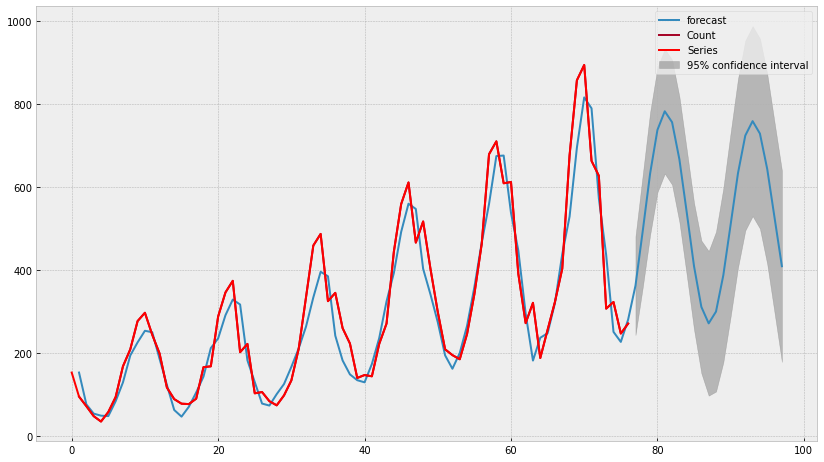

In [31]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    best_mdl.plot_predict(1, len(series)+20, ax=ax)
    plt.plot(series, color='red', label='Series')
    plt.legend()
    plt.show()

# Прогноз с использованием классического ML

In [40]:
monthly_sales = pd.read_csv("/Users/glebmutovin/Data_Science/DataScience_Netology/Machine_learning/TimeSeries/1._Лекция/Series/monthly-sales-of-company-x-jan-6.csv")

In [53]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):
    
    data = pd.DataFrame(data.copy())
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.Count.shift(i)
        
    data = data.dropna()
    data = data.reset_index(drop=True)
    data = data.drop(["Month"], axis=1)
     
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["Count"], axis=1)
    y_train = data.loc[:test_index]["Count"]
    X_test = data.loc[test_index:].drop(["Count"], axis=1)
    y_test = data.loc[test_index:]["Count"]
    
    return X_train, X_test, y_train, y_test

In [60]:
X_train, X_test, y_train, y_test = prepareData(monthly_sales, lag_start=5, lag_end=20, test_size=0.4)

In [43]:
pip install xgboost

You should consider upgrading via the '/Users/glebmutovin/Downloads/ENTER/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [44]:
from xgboost import XGBRegressor

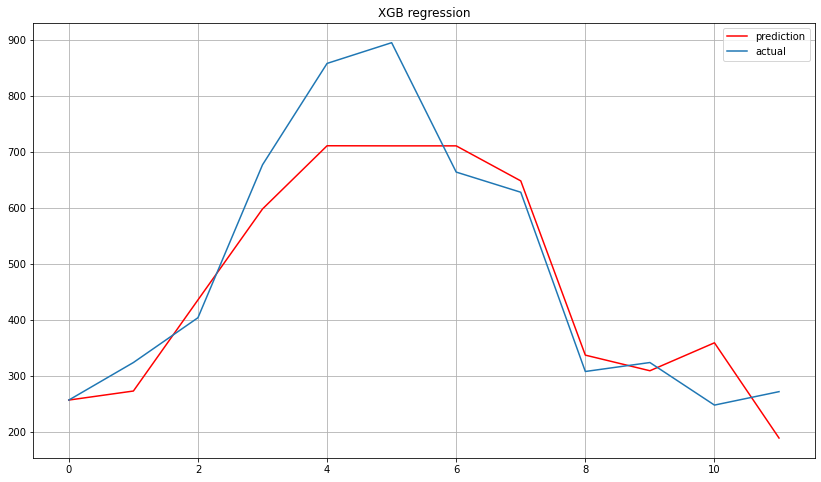

In [61]:
xgbr = XGBRegressor()
xgbr.fit(X_train, y_train)
prediction = xgbr.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("XGB regression")
plt.grid(True);

In [62]:
from sklearn.ensemble import RandomForestRegressor

In [81]:
regr = RandomForestRegressor(max_depth=20, min_samples_leaf=2, bootstrap=False)

In [82]:
regr.fit(X_train, y_train)
prediction = regr.predict(X_test)

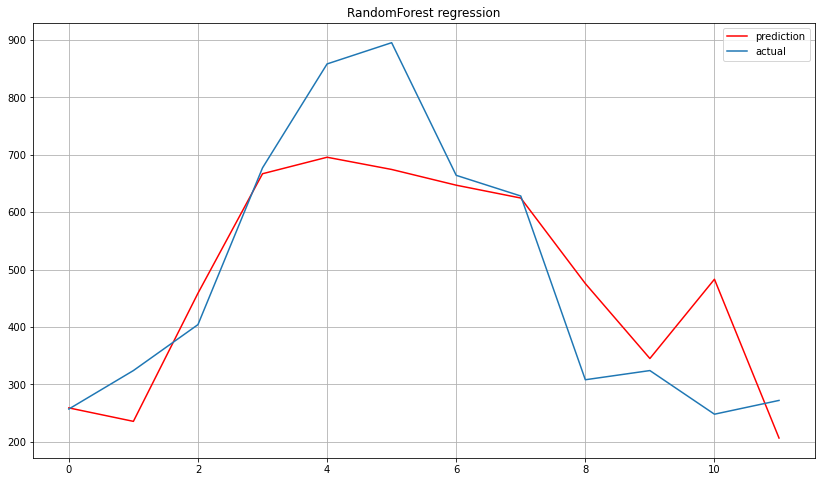

In [83]:
plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("RandomForest regression")
plt.grid(True);